# HW 2: Autoencoders
Carl Justin de Guia
2011-06521

## Model used
For the encoder, we use an input layer,2 convolutional layers (a 32-filter and 64-filter layer) that will return a (7,7,64) data which will then be flattened and ran through a dense layer to create a 32-dimensional latent vector. 

For the decoder, we use the same parameters for the 2 Conv2DTranspose(), and a 1-filter Conv2DTranspose layer with a sigmoid activation function that returns a "denoised" (28, 28, 1) image.

## Parameters
### Epoch
As seen from the model loss chart below, the loss is still going down at 10 epochs, and stopping at an earlier time will not return the best output. But when training at 15 epochs, patterns of overfitting are seen as show in the chart below, and the minimal improvement in the model benchmarks is not worth the longer training time.

*10 epochs*

![10 epoch](https://github.com/carldegs/EE-298Z/blob/master/HW2%20-%20Autoencoders/loss-base.png?raw=true)

*15 epochs*

![15 epoch](https://github.com/carldegs/EE-298Z/blob/master/HW2%20-%20Autoencoders/loss-15-epoch.png?raw=true)

### Kernel Size
The kernel size is also tested. Comparing a 2x2, a 3x3 and a 5x5 kernel results in the following benchmarks

| Kernel Size | Test Loss | Classifier Score | SSIM Score |
|-------------|-----------|------------------|------------|
| 2           | 0.01944   | 92.18            | 87.29      |
| 3           | 0.01670   | 93.76            | 89.37      |
| 5           | 0.01511   | 94.66            | 90.38      |

Even though the 5x5 shows the best results, it takes a far longer time to train. That's why I used a 3x3 kernel for my final model.

### Latent Dimensions
In theory, a larger latent vector will result in a more accurate denoising model but a very large latent vector will cause the latent representation to be overcomplete. With this is mind, I tested using an 8-dim, 16-dim and 32-dim in the model. These are their benchmark results:

| Latent Dimensions | Test Loss | Classifier Score | SSIM Score |
|-------------------|-----------|------------------|------------|
| 8                 | 0.02389   | 88.18            | 81.66      |
| 16                | 0.01670   | 93.76            | 89.37      |
| 32                | 0.01216   | 96.16            | 94.13      |

Since the change between 16 and 32 dimensions are significant, I used 32 ;latent dimensions in my model.

### Conv Layers and Filters
I tried 2 setups for the convolutional layers. Both are a 2-layer network but the first one has [16, 32] filters, and the other one has [32, 64] filters.

| Filters per layer | Test Loss | Classifier Score | SSIM Score |
|-------------------|-----------|------------------|------------|
| 16, 32            | 0.02639   | 86.53            | 79.21      |
| 32, 64            | 0.01670   | 93.76            | 89.37      |

With this, the final model uses 32 and 64 layers for the model.

### Activation Function
Since our input are positive numbers from [0, 1], ReLU is ideal for our use case. But I also tested using tanh, and it returned a worse benchmark than ReLU.

| Activation | Test Loss | Classifier Score | SSIM Score |
|------------|-----------|------------------|------------|
| tanh       | 0.00000   | 00.00            | 00.00      |
| ReLU       | 0.01670   | 93.76            | 89.37      |


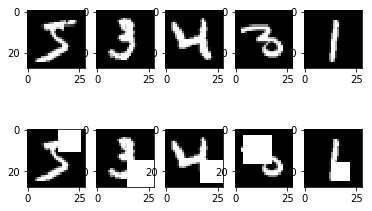

In [112]:
# Data generation
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
from hw2.transforms import corrupt_mnist_copy
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train_corrupted = corrupt_mnist_copy(x_train)
x_test_corrupted = corrupt_mnist_copy(x_test)

# Reshape to (28, 28, 1)
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_train_corrupted = np.reshape(x_train_corrupted, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_test_corrupted = np.reshape(x_test_corrupted, [-1, image_size, image_size, 1])

# Scale to [0, 1]
x_train = x_train.astype(K.floatx()) / 255.
x_train_corrupted = x_train_corrupted.astype(K.floatx()) / 255.
x_test = x_test.astype(K.floatx()) / 255.
x_test_corrupted = x_test_corrupted.astype(K.floatx()) / 255.

# Show sample image
f, axarr = plt.subplots(2, 5)
samples = [0, 10, 20, 30, 40];
for idx, sample in enumerate(samples):
    axarr[0,idx].imshow(x_train[sample][:,:,0], cmap='gray')
    axarr[1,idx].imshow(x_train_corrupted[sample][:,:,0], cmap='gray')

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 14, 14, 32)        832       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 7, 7, 64)          51264     
_________________________________________________________________
flatten_21 (Flatten)         (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 32)                100384    
Total params: 152,480
Trainable params: 152,480
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output 

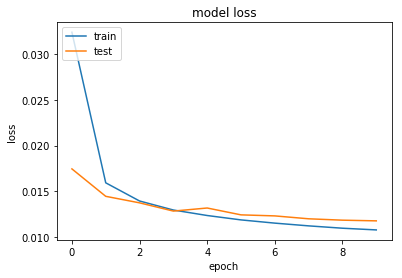

In [113]:
# Create and train autoencoder

# Setup network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
epochs = 10
kernel_size = 5 # TODO: Test kernel sizes [2, 3, 5]
latent_dim = 32 # TODO: Test different dimensions. [4, 8, 16, 32]
layer_filters = [32, 64] # TODO: Test differnt number of CNN layers [2, 3, 4] and filters per layer [32, 64, 128]
strides = 2
activation = 'relu'
padding = 'same'

# Build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# create the CNN layers
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides, # TODO; try other strides
               activation=activation, # TODO: try other activation fnx
               padding=padding)(x)

shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# Build decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=strides,
                        activation=activation,
                        padding=padding)(x)

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# Instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# Compile and train
autoencoder.compile(loss='mse', optimizer='adam')
history = autoencoder.fit(x_train_corrupted,
                x_train,
                validation_data=(x_test_corrupted, x_test),
                epochs=epochs,
                batch_size=batch_size,
                verbose=0)

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(28, 28, 1)
Row 1: Original image, Row 2: Corrupted image, Row 3: Decoded image


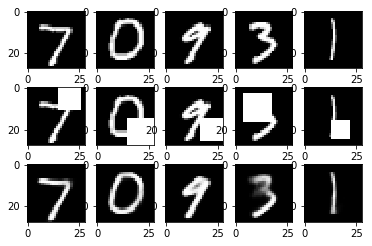

In [118]:
# Decode corrupted data
x_test_decoded = autoencoder.predict(x_test_corrupted)

f, axarr = plt.subplots(3, 5)
samples = [0, 10, 20, 30, 40];
for idx, sample in enumerate(samples):
    axarr[0,idx].imshow(x_test[sample][:,:,0], cmap='gray')
    axarr[1,idx].imshow(x_test_corrupted[sample][:,:,0], cmap='gray')
    axarr[2,idx].imshow(x_test_decoded[sample][:,:,0], cmap='gray')
    
print(x_test_decoded[0].shape)
print('Row 1: Original image, Row 2: Corrupted image, Row 3: Decoded image')

In [116]:
# Benchmarking
from hw2.benchmark_keras_test import test_model
(x_train_2, y_train_2), (x_test_2, y_test_2) = mnist.load_data()
x_test_2 = x_test_2.astype(K.floatx()) / 255.
test_model(autoencoder, x_test_2, y_test_2, batch_size=100)

Classifier score: 96.08
SSIM score: 94.50
